# Project 1: Life expectancy in lower-middle-income countries

# Business Understanding

Life expectancy is a key indicator of a country’s overall health and development. For developing countries, improving life expectancy is a pressing issue as it reflects progress in healthcare, sanitation, and economic conditions. This project aims to analyse and identify the strongest predictors of life expectancy in order to help policymakers and public health organisations better allocate resources and design target interventions to improve health outcomes. We can ask some important questions to help inform these decisions:
- Given time and budget contraints, where should we focus our efforts to maximise health outcomes?
- How has life expectancy changed over time? Can we see our policies working?
- Which countries have the highest and lowest life expectancy? What can we learn from them?

# Data Understanding

Data from the Health Nutrition and Population Statistics from the World Bank DataBank will be used for this project. It will include data from the years 2000-2021.

#### Load and inspect data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats

In [3]:
# Load dataset
health_dataset = pd.read_csv("Lower_Middle_DataBank_Health_Nutrition_and_Population_Statistics.csv")
health_dataset.head()

,Series Name,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Life expectancy at birth, total (years)",Angola,46.024,46.59,47.386,49.617,50.592,51.57,52.369,53.642,...,58.623,59.307,60.04,60.655,61.092,61.68,62.144,62.448,62.261,61.643
1,"Life expectancy at birth, total (years)",Bangladesh,65.779,66.135,66.612,66.824,67.187,67.299,67.241,66.714,...,69.554,69.565,69.986,70.491,71.09,71.788,72.567,72.806,71.968,72.381
2,"Life expectancy at birth, total (years)",Benin,56.578,56.66,56.606,56.738,56.826,57.125,57.456,57.675,...,58.716,58.965,59.125,59.377,59.539,59.856,60.14,60.454,60.088,59.821
3,"Life expectancy at birth, total (years)",Bhutan,62.01,63.444,64.078,64.696,65.268,65.805,66.362,66.954,...,69.326,69.707,70.049,70.343,70.602,70.847,71.129,71.391,71.609,71.815
4,"Life expectancy at birth, total (years)",Bolivia,62.346,62.843,63.306,63.635,64.004,64.386,64.779,65.027,...,66.705,67.021,67.163,67.318,67.628,67.701,67.748,67.841,64.467,63.63


In [4]:
# Identify data types
health_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Series Name   255 non-null    object
 1   Country Name  255 non-null    object
 2   2000          255 non-null    object
 3   2001          255 non-null    object
 4   2002          255 non-null    object
 5   2003          255 non-null    object
 6   2004          255 non-null    object
 7   2005          255 non-null    object
 8   2006          255 non-null    object
 9   2007          255 non-null    object
 10  2008          255 non-null    object
 11  2009          255 non-null    object
 12  2010          255 non-null    object
 13  2011          255 non-null    object
 14  2012          255 non-null    object
 15  2013          255 non-null    object
 16  2014          255 non-null    object
 17  2015          255 non-null    object
 18  2016          255 non-null    object
 19  2017    

# Data Preparation

#### Restructure the data to make it easier to work with

In [5]:
# Transform year into a variable
health_df = health_dataset.melt(id_vars=['Country Name', 'Series Name'], 
                  var_name='Year', 
                  value_name='Value')

# Convert year and value column to numeric
health_df['Year'] = pd.to_numeric(health_df['Year'], errors='coerce')
health_df['Value'] = pd.to_numeric(health_df['Value'], errors='coerce')

# Pivot data to make each variable a column
health_df_pivot = health_df.pivot_table(index=["Country Name", "Year"], columns="Series Name", values="Value")

# Reset index
health_df_pivot = health_df_pivot.reset_index()

health_df_pivot.head()

Series Name,Country Name,Year,Current health expenditure (% of GDP),"Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)",People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population)
0,Angola,2000,1.908599,46.024,120.7,41.144310,27.557524
1,Angola,2001,4.483516,46.590,117.5,42.254676,28.989223
2,Angola,2002,3.329461,47.386,113.7,43.376800,30.422469
3,Angola,2003,3.547973,49.617,109.5,44.363873,31.856061
4,Angola,2004,3.967199,50.592,104.9,45.351335,33.290391


#### Handle missing values

In [6]:
# Print data types and check for nulls
health_df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 7 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Country Name                                                           1122 non-null   object 
 1   Year                                                                   1122 non-null   int64  
 2   Current health expenditure (% of GDP)                                  1087 non-null   float64
 3   Life expectancy at birth, total (years)                                1122 non-null   float64
 4   Mortality rate, infant (per 1,000 live births)                         1122 non-null   float64
 5   People using at least basic drinking water services (% of population)  1116 non-null   float64
 6   People using at least basic sanitation services (% of population)      1116 non-null   fl

In [7]:
# Define function to display null rows
def show_nulls(data, columns):
    """
    Show null values for each feature
    Arguments:
        data: pivoted DataFrame
        columns: chosen features
    """
    for col in columns:
        nulls = data[data[col].isna()] # Filter rows where column has null values
        print(f"Rows with null values in '{col}':")
        display(nulls)

In [8]:
# Show nulls
columns_with_nulls = ['Current health expenditure (% of GDP)',
                      'People using at least basic drinking water services (% of population)',
                      'People using at least basic sanitation services (% of population)',
                     ]
show_nulls(health_df_pivot, columns_with_nulls)

Rows with null values in 'Current health expenditure (% of GDP)':


Series Name,Country Name,Year,Current health expenditure (% of GDP),"Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)",People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population)
946,Timor-Leste,2000,NaN,58.568,87.3,NaN,NaN
947,Timor-Leste,2001,NaN,59.362,83.7,NaN,NaN
948,Timor-Leste,2002,NaN,60.148,80.2,50.623852,35.229017
1056,West Bank and Gaza,2000,NaN,70.388,25.3,90.647856,90.339912
1057,West Bank and Gaza,2001,NaN,69.887,24.6,91.051576,90.392380
1058,West Bank and Gaza,2002,NaN,70.969,23.9,91.454491,90.444766
1059,West Bank and Gaza,2003,NaN,71.053,23.3,91.856515,90.496980
1060,West Bank and Gaza,2004,NaN,71.182,22.6,92.257753,90.979875
1061,West Bank and Gaza,2005,NaN,72.067,22.0,92.658113,91.462090
1062,West Bank and Gaza,2006,NaN,71.915,21.3,93.057654,91.943686


Rows with null values in 'People using at least basic drinking water services (% of population)':


Series Name,Country Name,Year,Current health expenditure (% of GDP),"Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)",People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population)
196,Comoros,2020,5.865220,64.166,40.5,NaN,NaN
197,Comoros,2021,6.335131,63.417,39.3,NaN,NaN
615,"Micronesia, Fed. Sts.",2021,10.960591,70.710,21.1,NaN,NaN
703,Nicaragua,2021,9.683432,73.837,13.5,NaN,NaN
946,Timor-Leste,2000,NaN,58.568,87.3,NaN,NaN
947,Timor-Leste,2001,NaN,59.362,83.7,NaN,NaN


Rows with null values in 'People using at least basic sanitation services (% of population)':


Series Name,Country Name,Year,Current health expenditure (% of GDP),"Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)",People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population)
196,Comoros,2020,5.865220,64.166,40.5,NaN,NaN
197,Comoros,2021,6.335131,63.417,39.3,NaN,NaN
615,"Micronesia, Fed. Sts.",2021,10.960591,70.710,21.1,NaN,NaN
703,Nicaragua,2021,9.683432,73.837,13.5,NaN,NaN
946,Timor-Leste,2000,NaN,58.568,87.3,NaN,NaN
947,Timor-Leste,2001,NaN,59.362,83.7,NaN,NaN


In [9]:
# Remove West Bank and Gaza and Zimbabwe from dataset as significant number of values missing for multiple years
countries_to_remove = ['West Bank and Gaza', 'Zimbabwe']
health_df_pivot_no_nulls = health_df_pivot[~health_df_pivot['Country Name'].isin(countries_to_remove)]
health_df_pivot_no_nulls = health_df_pivot_no_nulls.reset_index(drop=True)
health_df_pivot_no_nulls.head()

Series Name,Country Name,Year,Current health expenditure (% of GDP),"Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)",People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population)
0,Angola,2000,1.908599,46.024,120.7,41.144310,27.557524
1,Angola,2001,4.483516,46.590,117.5,42.254676,28.989223
2,Angola,2002,3.329461,47.386,113.7,43.376800,30.422469
3,Angola,2003,3.547973,49.617,109.5,44.363873,31.856061
4,Angola,2004,3.967199,50.592,104.9,45.351335,33.290391


In [10]:
# Interpolate each feature to fill in missing data

# Interpolate using linear interpolation
for column in health_df_pivot_no_nulls.columns:
    if column not in ['Country Name', 'Year']:  # Skip non-numeric columns
        health_df_pivot_no_nulls.loc[:, column] = health_df_pivot_no_nulls.groupby('Country Name')[column] \
            .apply(lambda group: group.interpolate(method='linear', limit_direction='both')) \
            .reset_index(level=0, drop=True)

# Check there are no remaning nulls
print(health_df_pivot_no_nulls.isna().sum())

# Set new name
health_df_cleaned = health_df_pivot_no_nulls

Series Name
Country Name                                                             0
Year                                                                     0
Current health expenditure (% of GDP)                                    0
Life expectancy at birth, total (years)                                  0
Mortality rate, infant (per 1,000 live births)                           0
People using at least basic drinking water services (% of population)    0
People using at least basic sanitation services (% of population)        0
dtype: int64


Interpolation has been chosen to avoid data loss. Specifically, linear interpolation has been used as it's reasonable to assume a somewhat gradual trend year on year for our features. One thing to note is that using linear interpolation uses two points of data to interpolate a value, however all null values occur at either the beginning or end of our date range with at least one point of data missing either side, so this will result in the nearest year's value being used.

#### Visualise cleaned dataset

In [11]:
# Generate descriptive statistics
health_df_cleaned.describe()

Series Name,Year,Current health expenditure (% of GDP),"Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)",People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population)
count,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000
mean,2010.500000,5.080918,64.920941,41.958813,75.513751,52.522221
std,6.347233,2.343578,7.241807,21.882515,15.559226,26.393730
min,2000.000000,1.505008,42.125000,5.700000,28.666422,6.245732
25%,2005.000000,3.521640,60.815250,22.725000,64.594781,30.977738
50%,2010.500000,4.527893,65.874000,39.450000,77.326569,48.589045
75%,2016.000000,6.222212,70.351750,57.550000,88.537696,74.100262
max,2021.000000,17.733067,79.729000,120.700000,99.126995,99.200000


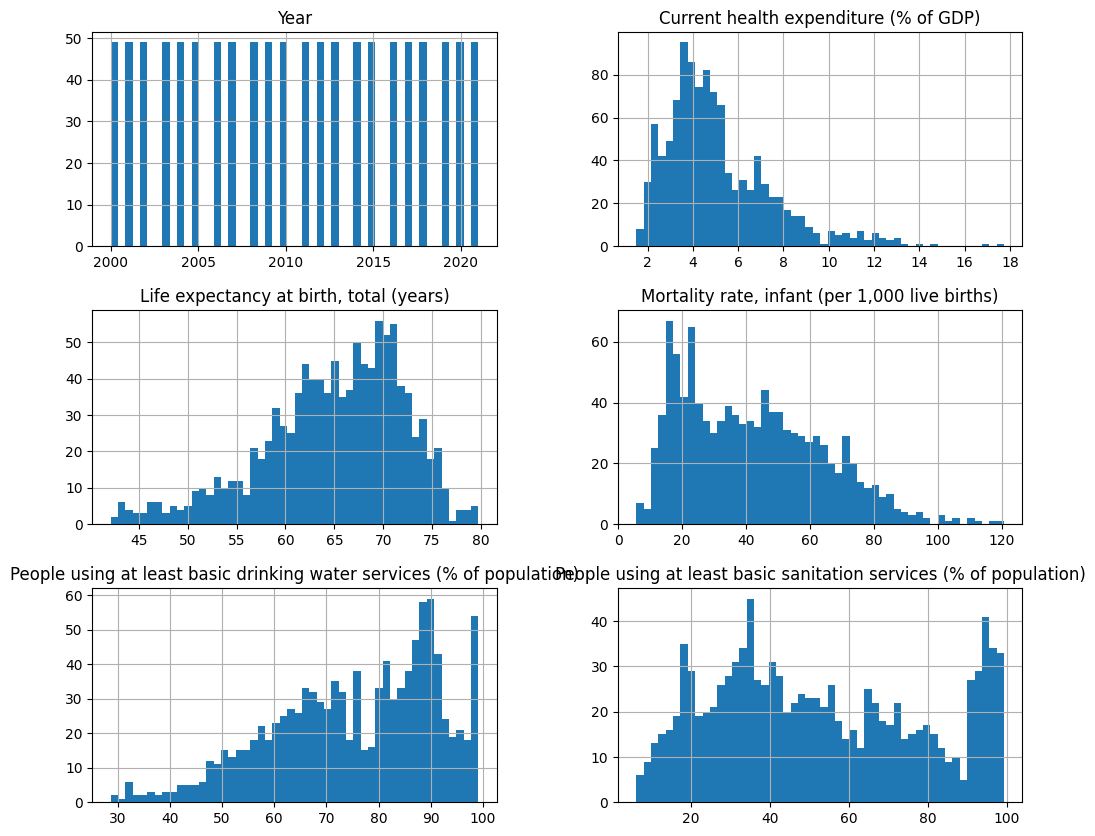

In [12]:
# Plot histograms of the features
health_df_cleaned.hist(bins=50, figsize=(12, 10))
plt.show()

In [13]:
# Calculate correlation matrix of the features
health_df_numerical = health_df_cleaned.select_dtypes(include=[np.number])
corr_matrix = health_df_numerical.corr()
corr_matrix["Life expectancy at birth, total (years)"].sort_values(ascending=False)

Series Name
Life expectancy at birth, total (years)                                  1.000000
People using at least basic drinking water services (% of population)    0.692469
People using at least basic sanitation services (% of population)        0.674455
Year                                                                     0.293041
Current health expenditure (% of GDP)                                    0.183491
Mortality rate, infant (per 1,000 live births)                          -0.880750
Name: Life expectancy at birth, total (years), dtype: float64

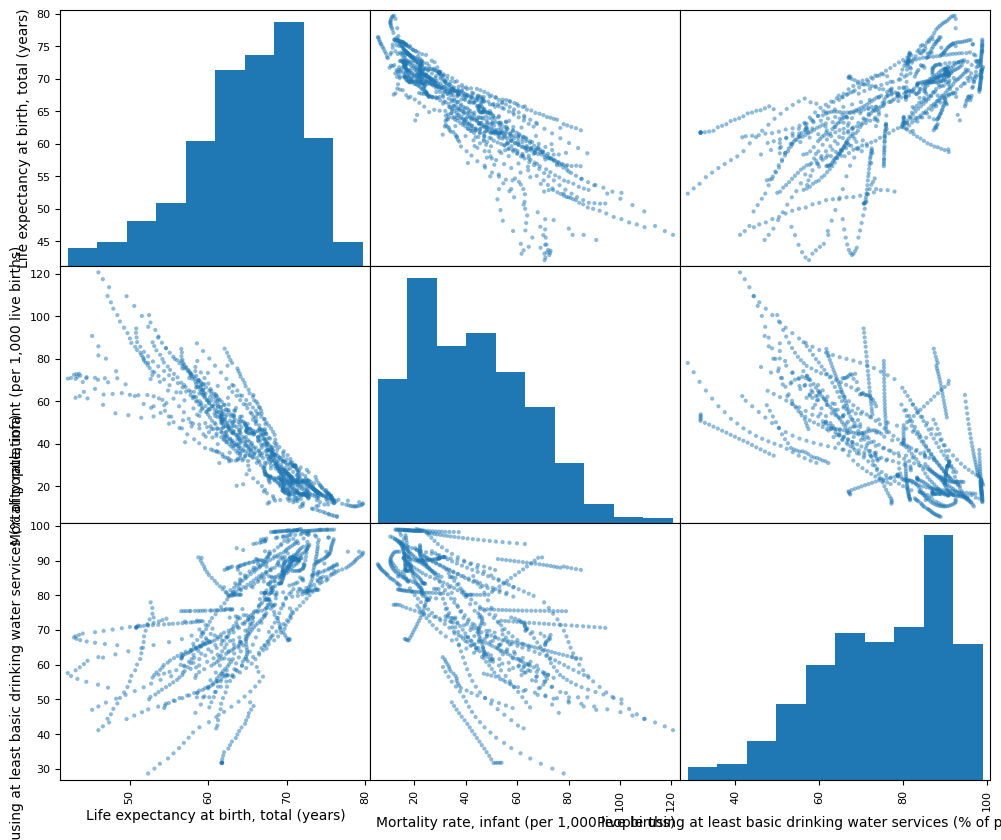

In [14]:
# Plot most important feature pairs with scatter plot
from pandas.plotting import scatter_matrix

features = ["Life expectancy at birth, total (years)", "Mortality rate, infant (per 1,000 live births)", "People using at least basic drinking water services (% of population)"]

scatter_matrix(health_df_cleaned[features], figsize=(12, 10))
plt.show()

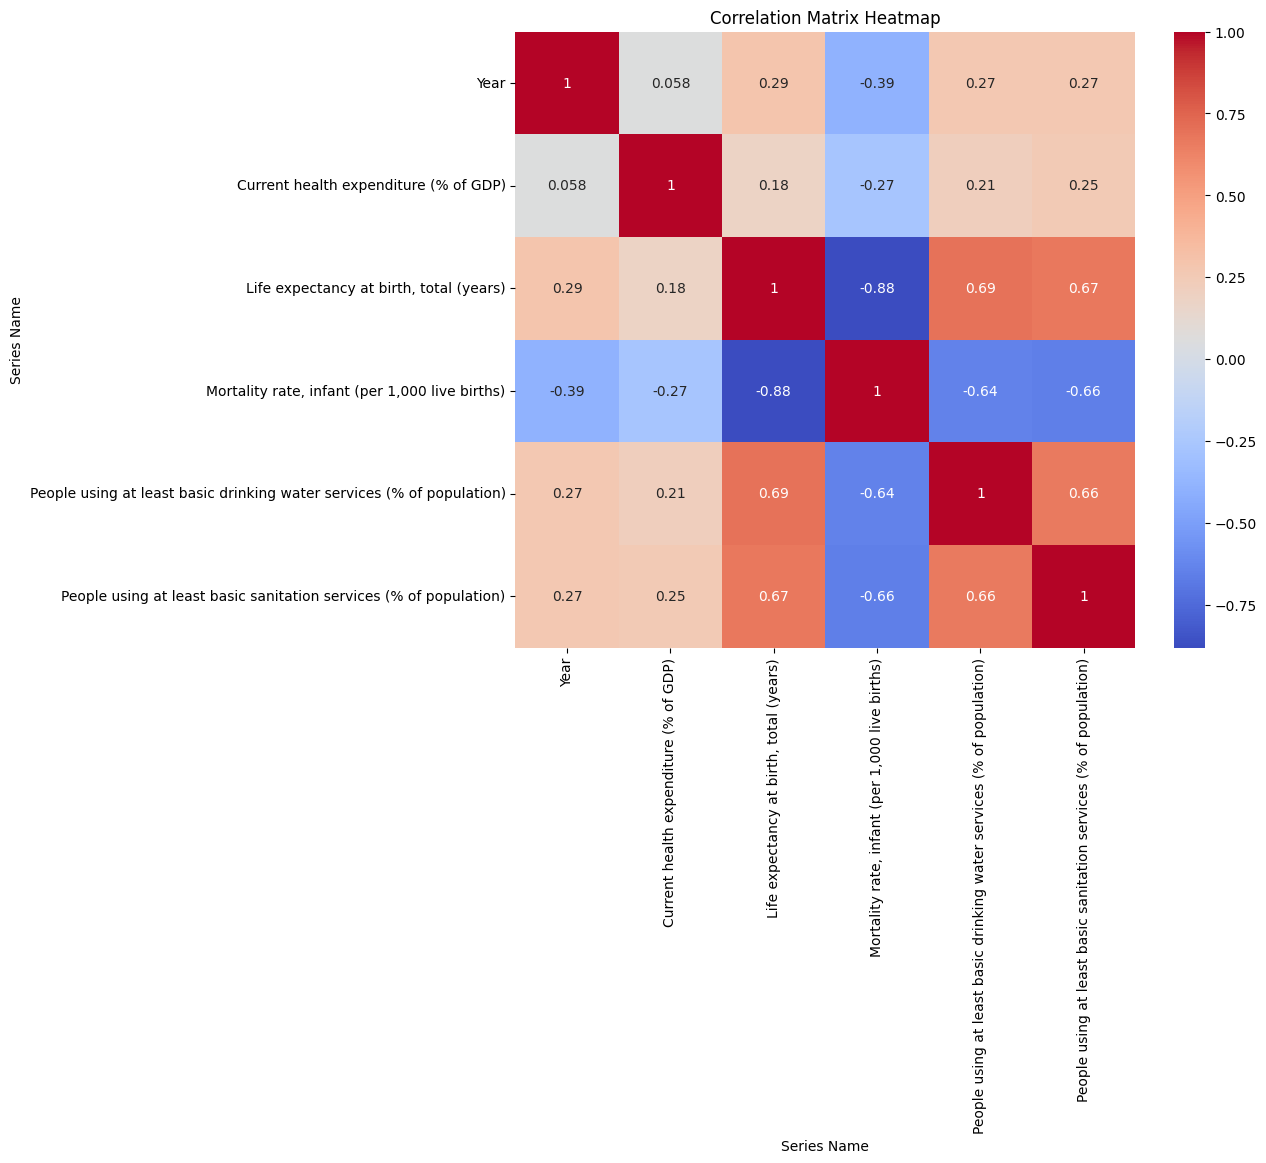

In [15]:
# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

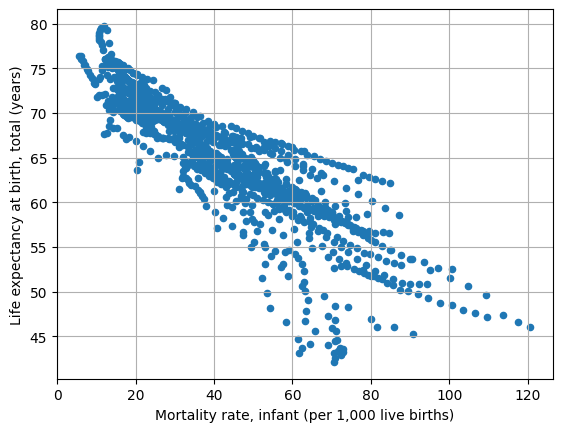

In [16]:
# Choose the most important feature and plot it against the target
health_df_cleaned.plot(kind="scatter", x="Mortality rate, infant (per 1,000 live births)", y="Life expectancy at birth, total (years)", grid=True)
plt.show()

# Data Modelling

#### Select and fit model

Use a mixed-effects model (linear mixed model) to account for differences between countries while identifying global trends

In [17]:
# Convert categorical variables
health_df_cleaned['Country Name'] = health_df_cleaned['Country Name'].astype("category")
health_df_cleaned['Year'] = health_df_cleaned['Year'].astype(int)

In [18]:
# Define the mixed-effects model
model = smf.mixedlm(
    "Q('Life expectancy at birth, total (years)') ~ "
    "Q('Current health expenditure (% of GDP)') + "
    "Q('Mortality rate, infant (per 1,000 live births)') + "
    "Q('People using at least basic drinking water services (% of population)') + "
    "Q('People using at least basic sanitation services (% of population)') + Year",
    health_df_cleaned,
    groups=health_df_cleaned["Country Name"])

# Fit the model
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                                         Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          Q('Life expectancy at birth, total (years)')
No. Observations:            1078             Method:                      REML                                        
No. Groups:                  49               Scale:                       1.5094                                      
Min. group size:             22               Log-Likelihood:              -1892.3582                                  
Max. group size:             22               Converged:                   Yes                                         
Mean group size:             22.0                                                                                      
-----------------------------------------------------------------------------------------------------------------------
                                                                           Coef. 

# Evaluation

#### Checking model fit

In [19]:
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

health_df_cleaned["Predicted life expectancy"] = model_fit.predict(health_df_cleaned)

r2 = r2_score(
    health_df_cleaned["Life expectancy at birth, total (years)"],
    health_df_cleaned["Predicted life expectancy"]
)
mse = mean_squared_error(
    health_df_cleaned["Life expectancy at birth, total (years)"],
    health_df_cleaned["Predicted life expectancy"]
)
rmse = root_mean_squared_error(
    health_df_cleaned["Life expectancy at birth, total (years)"],
    health_df_cleaned["Predicted life expectancy"]
)

print(f"R^2 Score: {r2:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

R^2 Score: 0.757
Mean Squared Error (MSE): 12.754
Root Mean Squared Error (RMSE): 3.571


#### Interpreting model summary

##### Fixed effects

When looking at each of the fixed effects, we can see 'Mortality rate, infant (per 1,000 live births)' is the strongest predictor, followed by 'People using at least basic drinking water services (% of population)'. The P>|z| (P-value) tells us the probability that the coefficient is not significant, so with p < 0.001 for both these features we can assume they both have high statistical significance. Looking at the correlations, every increase of 1 infant death per 1,000 live births reduces life expectancy in that country by 0.205 years. As well, a 1% increase in population with basic drinking water increases life expectancy by 0.049 years.

The coefficient of 'Year' as a feature suggests life expectancy increases by 0.029 years per year and therefore shows a positive trend. The P-value tells us this feature also has some statistical significance at p = 0.029.

The model suggests 'People using at least basic sanitation services (% of population)' has no significant effect on life exectancy, with the coefficient nearly at 0 (-0.001) and p = 0.045, suggesting it is not statistically significant. Although we'd expect to see a positive correlation with access to sanitation services and life expectancy, this lack of correlation could be explained by the fact that if basic water access is already high, additional sanitation might not have a strong impact.

Unexpectedly, the model suggests that 'Current health expenditure (% of GDP)' has a slight negative effect on life expectancy. The coefficient is -0.063, meaning more spending on health correlates with slightly lower life expectancy. This feature is not statistically significant (p = 0.103), so it could be due to confounding factors. For example, although the countries in this data fall within the category of lower-middle income economies, their gross national income per capita ranges from 1,146 USD to 4,515 USD, and so GNI/GDP could be considered a confounder. The countries with GNI near the top end of this bracket may have better healthcare infrastructure, sanitation, and higher life expectancy than those at the lower end of the bracket. The relatively wealthier countries may spend a higher percentage of GDP on healthcare but also have longer life expectancy. Conversley, poorer countries in this group may spend more of their limited GDP on healthcare but still have worse health outcomes due to systemic poverty. A country with low GDP but high health spending as a % of GDP might appear to spend a lot, but in absolute terms, its healthcare system remains underfunded.

##### Random effects

The group variance shows us the country-level variation in life expectancy. A value of 11.556 tells us that life expectancy differs significantly between countries in the lower-middle income group, beyond what is explained by the fixed effects.

##### Model performance metrics

An R^2 value of 0.757 tells us that the model captures 75.7% of the variation in life expectancy, which is strong.

The RMSE value of 3.57 tells us our model's predictions are off by about 3.57 years on average.

#### Checking model assumptions

To make sure the model is valid and reliable, we need to check key assumptions such as linearity and normaility of residuals.

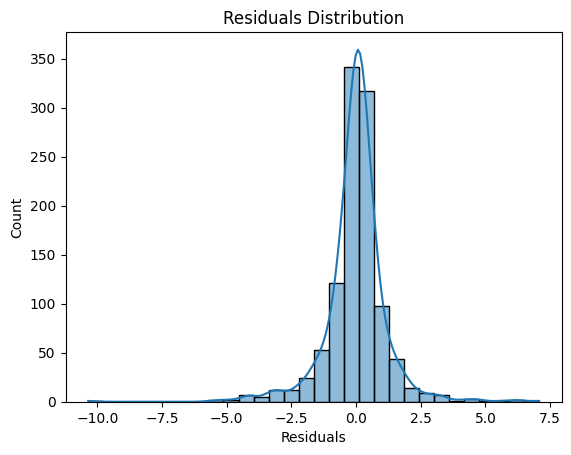

In [20]:
# Check residual distribution
sns.histplot(model_fit.resid, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()

The histogram appears roughly bell-shaped, centred around 0. There is some slight skewness at the tails but nothing extreme. The presence of some outliers on the far left and right tails suggests minor deviations from normality, but overall the residuals are close to normal.

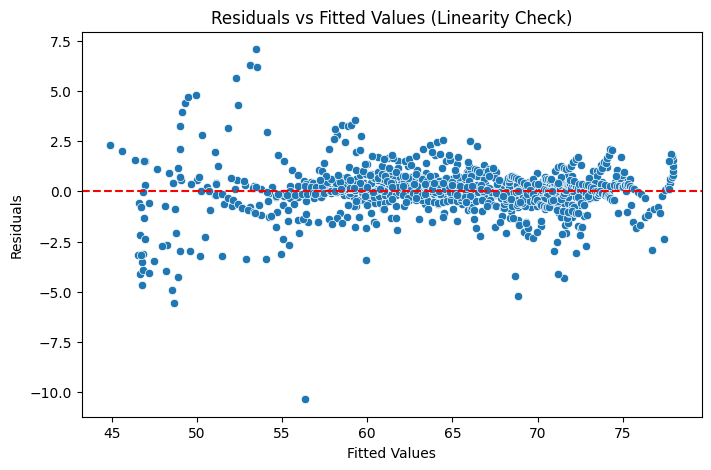

In [21]:
# Check linearity
# Get residuals and fitted vales
health_df_cleaned["Fitted"] = model_fit.fittedvalues
health_df_cleaned["Residuals"] = model_fit.resid

# Scatter pot of residuals vs. fitted values
plt.figure(figsize=(8,5))
sns.scatterplot(x=health_df_cleaned["Fitted"], y=health_df_cleaned["Residuals"])
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values (Linearity Check)")
plt.show()

The residuals are mostly scattered randomly around the red zero-line meaning there is no clear pattern, which is good. However, on the left the residuals show greater spread which suggests heteroscedasticity, meaning errors have larger variance for lower life expectancy values. The prescences of clusters or trends might indicate non-linearity in certain relationships or the need for transformation.

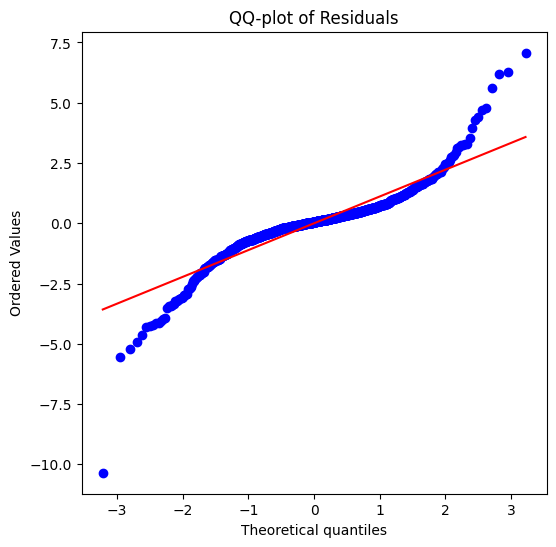

In [22]:
# Check a QQ-plot for residual normality
residuals = model_fit.resid
fig, ax = plt.subplots(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=ax)
plt.title("QQ-plot of Residuals")
plt.show()

The QQ plot suggests the presence of outliers or skewed residuals, and the S shape could indicate nonlinear relationships that the model isn't accounting for.

#### Potential next steps

Next steps could be:
- Log transformation of life expectancy variable
- Assess outliers
- Try a different model


# Real-World Prediction

### Predicting life exectancy in 2026 in Eswatini

#### Define a function for predicting life expectancy

In [23]:
def prediction(health_exp, mortality_rate, water_access, sanitation_access, country, year):
    """
    Predict life expectancy using given data
    Arguments:
        health_exp: Current health expenditure (% of GDP)
        mortality_rate: Mortality rate, infant (per 1,000 live births)
        water_access: People using at least basic drinking water services (% of population)
        sanitation_access: People using at least basic sanitation services (% of population)
        country: Country Name
        year = Year
    """
    # Define DataFrame
    df = ({
        "Current health expenditure (% of GDP)": health_exp,
        "Mortality rate, infant (per 1,000 live births)": mortality_rate,
        "People using at least basic drinking water services (% of population)": water_access,
        "People using at least basic sanitation services (% of population)": sanitation_access,
        "Country Name": country,
        "Year": year,
    })
    predicted_life_expectancy = model_fit.predict(df)
    return predicted_life_expectancy.iloc[0]

We will look at the current stats vs 4 policy changes:
- Policy 1: Increase % of GDP spent on healthcare to 8.0%.
- Policy 2: Focus on reducing infant mortality by 15% to 34 per 1,000 live births through better maternal care, vaccinations, nutrition, and neonatology.
- Policy 3: Invest in clean water facilities so that 86% of the population have access to basic drinking water.
- Policy 4: Infrastructure investment prioritized for sewer systems and wastewater treatment so that 76% of the population have access to basic sanitation services.

In [24]:
# Make prediction using current stats
current = prediction(7.0, 40, 75, 66, "Eswatini", 2026)

# Policy 1 prediction
policy1 = prediction(8.0, 40, 75, 66, "Eswatini", 2026)

# Policy 2 prediction
policy2 = prediction(7.0, 34, 75, 66, "Eswatini", 2026)

# Policy 3 prediction
policy3 = prediction(7.0, 40, 86, 66, "Eswatini", 2026)

# Policy 4 prediction
policy4 = prediction(7.0, 40, 75, 76, "Eswatini", 2026)

#### Visualise scenarios

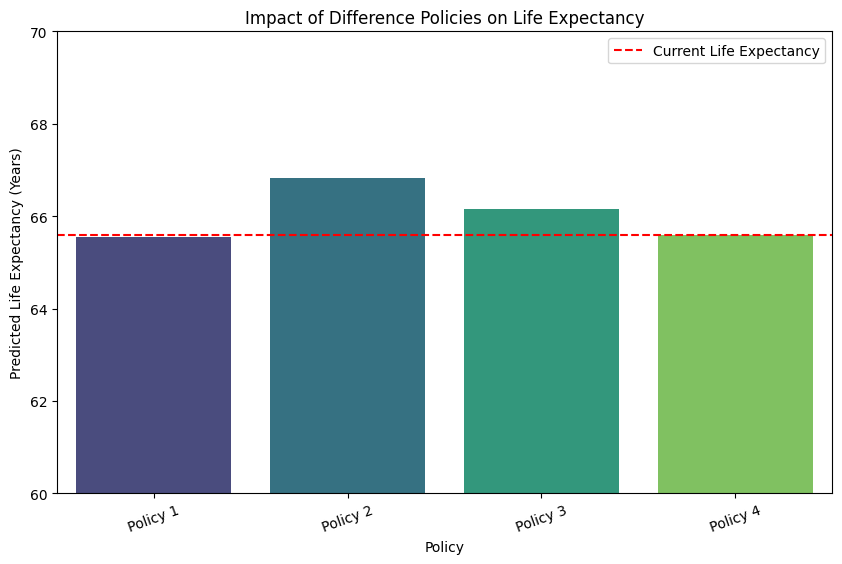

In [25]:
# Policies
policies = ["Policy 1", "Policy 2", "Policy 3", "Policy 4"]

# Difference in predicted life expectancy if that policy was implemented
predicted_life_expectancies = [policy1, policy2, policy3, policy4]

# Create bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=policies, y=predicted_life_expectancies, hue=policies, palette="viridis")

# Set y-axis limits
plt.ylim(60, 70)

# Add a horizontal line to represent the current life expectancy
plt.axhline(y=current, color="red", linestyle="--", label="Current Life Expectancy")

# Add labels and title
plt.xlabel("Policy")
plt.ylabel("Predicted Life Expectancy (Years)")
plt.title("Impact of Difference Policies on Life Expectancy")
plt.xticks(rotation=20) # Rotate labels for better readability
plt.legend() # Show ledgend for the current life expectancy line

# Show the plot
plt.show()

### Other insights

#### How has life expectancy changed over time?

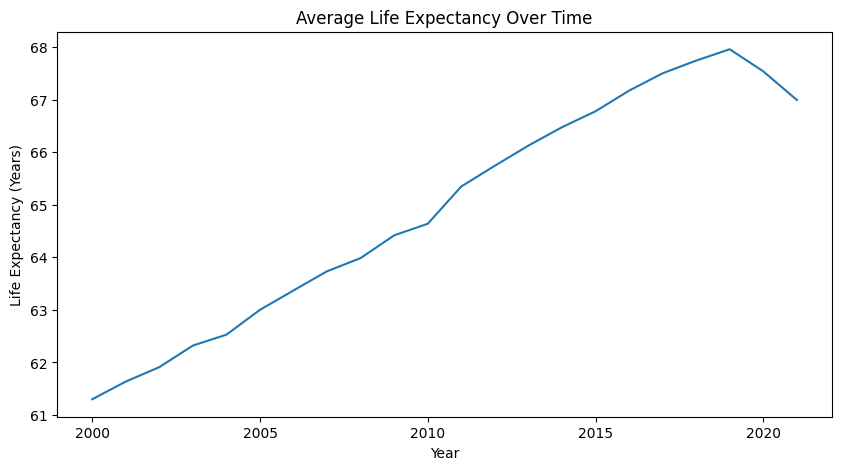

In [26]:
plt.figure(figsize=(10,5))
sns.lineplot(data=health_df_cleaned, x="Year", y="Life expectancy at birth, total (years)", estimator="mean", errorbar=None)
plt.title("Average Life Expectancy Over Time")
plt.xlabel("Year")
plt.ylabel("Life Expectancy (Years)")
plt.show()

#### Which countries have the highest and lowest life expectancy?

In [27]:
from tabulate import tabulate

# Get the latest year of data
latest_year = health_df_cleaned["Year"].max()

# Filter for latest year and get top 5 and bottom 5 countries by life expectancy
top5 = health_df_cleaned[health_df_cleaned["Year"] == latest_year].nlargest(5, "Life expectancy at birth, total (years)")
bottom5 = health_df_cleaned[health_df_cleaned["Year"] == latest_year].nsmallest(5, "Life expectancy at birth, total (years)")

# Select only relevant columns for display
table_top5 = top5[["Country Name", "Life expectancy at birth, total (years)"]]
table_bottom5 = bottom5[["Country Name", "Life expectancy at birth, total (years)"]]

In [28]:
# Print top 5
print(f"Top 5 Countries by Life Expectancy ({latest_year})")
print(tabulate(table_top5, headers="keys", tablefmt="grid"))

Top 5 Countries by Life Expectancy (2021)
+-----+----------------+-------------------------------------------+
|     | Country Name   |   Life expectancy at birth, total (years) |
+=====+================+===========================================+
| 901 | Sri Lanka      |                                    76.399 |
+-----+----------------+-------------------------------------------+
| 549 | Lebanon        |                                    75.047 |
+-----+----------------+-------------------------------------------+
| 439 | Jordan         |                                    74.256 |
+-----+----------------+-------------------------------------------+
| 131 | Cabo Verde     |                                    74.052 |
+-----+----------------+-------------------------------------------+
| 637 | Morocco        |                                    74.042 |
+-----+----------------+-------------------------------------------+


In [29]:
# Print bottom 5
print(f"Bottom 5 Countries by Life Expectancy ({latest_year})")
print(tabulate(table_bottom5, headers="keys", tablefmt="grid"))

Bottom 5 Countries by Life Expectancy (2021)
+-----+----------------+-------------------------------------------+
|     | Country Name   |   Life expectancy at birth, total (years) |
+=====+================+===========================================+
| 725 | Nigeria        |                                    52.676 |
+-----+----------------+-------------------------------------------+
| 571 | Lesotho        |                                    53.062 |
+-----+----------------+-------------------------------------------+
| 307 | Eswatini       |                                    57.066 |
+-----+----------------+-------------------------------------------+
| 241 | Cote d'Ivoire  |                                    58.598 |
+-----+----------------+-------------------------------------------+
| 351 | Guinea         |                                    58.892 |
+-----+----------------+-------------------------------------------+
